In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# time series forecasting with regression

We've walked through time series forecasting using only past values of the forecast variable $y$ — check out the "time series forecasting basics" notebook — but now we'd like to forecast a variable using one or multiple predictor variables $x$. This task calls for time series regression models.

In the simplest case, we have a single forecast variable and a single predictor variable, related linearly: $y_{t} = \beta_{0} + \beta_{1} x_{t} + \epsilon_{t}$. The model's parameters include an intercept $\beta_{0}$, slope $\beta_{1}$, and "error" $\epsilon_{t}$ describing deviations between the straight line prediction and actual observations — basically, everything affecting $y_{t}$ other than $x_{t}$. When there are multiple predictor variables, we generalize simple linear regression into a multiple regresison model: $y_{t} = \beta_{0} + \beta_{1} x_{1,t} + \cdots + \beta_{k} x_{k, t} + \epsilon_{t}$, where $k$ is the number of predictor variables and $\beta$ coefficients represent the marginal effects of each predictor on the forecast variable.

When using linear regression, we're making some key assumptions about the errors $\epsilon_{t}$:

- they have a mean of zero, otherwise forecasts will be biased
- (ideally) they're normally distributed with constant variance, otherwise forecast intervals will be more work
- they're not autocorrelated, otherwise the model isn't using all available information
- they're unrelated to the predictor variables, otherwise we're not providing enough information to the model

## technical setup

Check out the repo's readme for installation instructions, then:

In [3]:
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.model_selection
import statsmodels.api as sm

import data_dives
from data_dives import time_series_forecasting as tsf

In [4]:
# set some default plot params
plt.rcParams.update(
    {
        "figure.figsize": (16, 6),
        "figure.facecolor": "white",
        "axes.labelsize": "x-large",
        "legend.fontsize": "x-large",
        "legend.frameon": False,
        "lines.linewidth": 2,
    }
)

## problem definition

Let's build on our "basic" exploration into forecasting atmospheric CO2 concentrations, and now use it as a _predictor_ variable for global temperature forecasts. The original problem definition just needs a couple tweaks:

Climate change is a large and growing existential threat to life on our planet, and global warming is a particularly notable component of these changes. Human-caused emission of greenhouse gasses (GHGs) into the atmosphere is a direct and dominant driver of global warming. Can we predict future global temperatures over the course of the next ten years based on different GHG emission scenarios, in order to show a reasonable range of possible climate futures?

## information gathering

Global warming is driven by the increasing concentration of GHGs in the atmosphere, as predominantly emitted by humans [[source](https://climate.nasa.gov/causes/)]. We previously found that a good, long-term source of atmospheric CO2 concentration measurements is the Mauna Loa Observatory, so we'll use that dataset for our predictor variable. (Other variables affecting global temperature include aerosols and solar activity, but corresponding datasets are lacking.)

Measuring average global temperature is more difficult than one might expect; in practice, scientists typically consider temperature _anomalies_ that indicate how much warmer / colder it is than "normal" for a particular place and time [[source](https://data.giss.nasa.gov/gistemp/faq/abs_temp.html)]. This process requires combining thousands of land- and sea-based measurements, normalizing them against appropriate historical averages to produce temperature "anomalies", splitting the globe up into a grid and averaging over each square, filling gaps in coverage, then repeating this process over and over in time [[source](https://www.carbonbrief.org/explainer-how-do-scientists-measure-global-temperature)].

### data acquisition

Several independent datasets exist with such information, including NASA's GISS Surface Temperature analysis ([GISTEMP](https://data.giss.nasa.gov/gistemp)) and NOAA's Merged Land–Ocean Surface Temperature analysis ([MLOST](https://www.ncdc.noaa.gov/data-access/marineocean-data/mlost)). They differ in their spatial coverage and how they handle measurement errors / changes, among other things. Since GISTEMP is well-known and has the best global coverage, let's go with it. Some important details:

- GISTEMP uses 1951-1980 as the reference period against which anomalies are determined
- measurements are available from 1880–present, where the starting point was decided by 19th-century data quality issues
- values are "Land-Ocean Temperature Index" (LOTI) anomalies that combine land surface air temps and sea surface temps, in units of degrees Celsius
- we're using data with monthly temporal resolution and global spatial resolution

In [5]:
dataset_temp = data_dives.datasets.GISTEMP()
dataset_temp.info

{'name': 'GISTEMP',
 'site_url': 'https://data.giss.nasa.gov/gistemp',
 'description': 'Estimates of global surface temperature change based on combined land-surface air and sea-surface water temperature anomalies, expressed as a Land-Ocean Temperature Index (LOTI) measured relative to average temps over 1951-1980 for the given place and time of year. Global mean with monthly resolution, 1880 – Present.',
 'citation': 'Lenssen, N., G. Schmidt, J. Hansen, M. Menne, A. Persin, R. Ruedy, and D. Zyss, 2019: Improvements in the GISTEMP uncertainty model. J. Geophys. Res. Atmos., 124, no. 12, 6307-6326, doi:10.1029/2018JD029522.',
 'download_url': 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'}

In [6]:
raw_data_temp = dataset_temp.load()
raw_data_temp

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.17,-0.23,-0.08,-0.15,-0.08,-0.20,-0.17,-0.09,-0.13,-0.22,-0.20,-0.16,-0.16,***,***,-0.10,-0.15,-0.18
1,1881,-0.18,-0.13,0.04,0.06,0.08,-0.17,0.02,-0.02,-0.14,-0.20,-0.17,-0.05,-0.07,-.08,-.16,0.06,-0.06,-0.17
2,1882,0.18,0.15,0.06,-0.15,-0.13,-0.21,-0.15,-0.06,-0.13,-0.23,-0.15,-0.34,-0.10,-.07,.09,-0.08,-0.14,-0.17
3,1883,-0.28,-0.36,-0.11,-0.17,-0.16,-0.07,-0.05,-0.12,-0.20,-0.10,-0.22,-0.10,-0.16,-.18,-.33,-0.15,-0.08,-0.17
4,1884,-0.12,-0.07,-0.36,-0.39,-0.33,-0.34,-0.32,-0.27,-0.26,-0.24,-0.32,-0.30,-0.28,-.26,-.10,-0.36,-0.31,-0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2016,1.17,1.37,1.35,1.12,0.96,0.81,0.85,1.02,0.91,0.89,0.91,0.86,1.02,1.04,1.24,1.14,0.89,0.90
137,2017,1.03,1.15,1.17,0.95,0.91,0.72,0.82,0.87,0.77,0.90,0.88,0.94,0.93,.92,1.02,1.01,0.80,0.85
138,2018,0.82,0.85,0.90,0.89,0.83,0.78,0.83,0.76,0.81,1.02,0.83,0.92,0.85,.85,.87,0.87,0.79,0.89
139,2019,0.94,0.96,1.18,1.02,0.86,0.93,0.95,0.94,0.93,1.02,1.01,1.09,0.99,.97,.94,1.02,0.94,0.98


### data preparation

Thanks to NASA researchers' efforts, this dataset is quite clean; however, we still need to wrangle it just a bit for our purposes:

- drop unnecessary aggregate columns like `"SON"` (September+October+November)
- restructure ("tidy") the data with one observation per row, and use a proper datetime index
- resample the frequency of observations, if desired, though in this use case we can stick with monthly values
- filter the time period covered by the dataset to match that of our predictor variable

In [7]:
data_temp = dataset_temp.prepare(raw_data_temp)
data_temp

,LOTI
dt,
1880-01-01,-0.17
1880-02-01,-0.23
1880-03-01,-0.08
1880-04-01,-0.15
1880-05-01,-0.08
...,...
2020-08-01,0.87
2020-09-01,0.99
2020-10-01,0.89


We'll load and prepare our MLO CO2 dataset as before, resampling to monthly frequency to match GISTEMP:

In [8]:
dataset_co2 = data_dives.datasets.MLOCO2()
dataset_co2.info

{'name': 'MLO CO2',
 'site_url': 'https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html',
 'description': 'In-situ CO2 measurements taken at Mauna Loa Observatory, Hawaii (Latitude 19.5°N, Longitude 155.6°W, Elevation 3397m). Daily resolution, from 1958 – Present.',
 'citation': 'C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and oceans from 1978 to 2000. I. Global aspects, SIO Reference Series, No. 01-06, Scripps Institution of Oceanography, San Diego, 88 pages, 2001.',
 'download_url': 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/daily/daily_in_situ_co2_mlo.csv'}

In [9]:
raw_data_co2 = dataset_co2.load()
data_co2 = dataset_co2.prepare(raw_data_co2, freq="MS", fill="interpolate")
data_co2

,CO2
dt,
1958-03-01,316.425
1958-04-01,317.438462
1958-05-01,317.471111
1958-06-01,316.598142
1958-07-01,315.753333
...,...
2020-09-01,411.315385
2020-10-01,411.292143
2020-11-01,413.000345


We filter the datasets to a shared date range by joining their indexes, via `pandas`:

In [10]:
data = (
    pd.merge(data_temp, data_co2, left_index=True, right_index=True, how="inner")
    .astype(float)
)
data

,LOTI,CO2
dt,,
1958-03-01,0.08,316.425000
1958-04-01,0.01,317.438462
1958-05-01,0.06,317.471111
1958-06-01,-0.09,316.598142
1958-07-01,0.05,315.753333
...,...,...
2020-08-01,0.87,412.551724
2020-09-01,0.99,411.315385
2020-10-01,0.89,411.292143


## exploratory data analysis

Let's do a quick exploration of our two variables: how they change over time, the distribution of their values, their relationship to each other, etc. For a deeper dive into the dependent variable, check out the "time series forecasting basics" notebook.

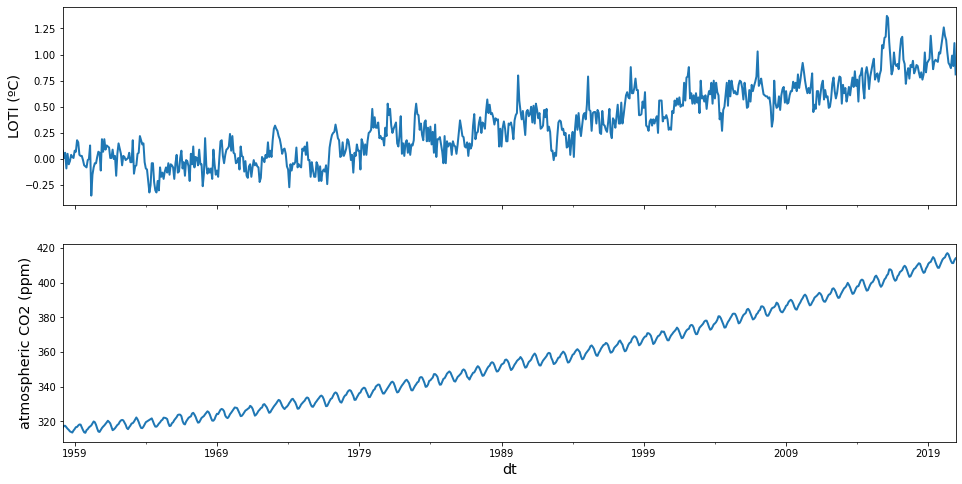

In [11]:
_ = tsf.viz.plot_time_series(
    [data["LOTI"], data["CO2"]],
    labels=["LOTI (ºC)", "atmospheric CO2 (ppm)"],
    figsize=(16, 8)
)

From the time plots above, we can see that both variables are trending upward at what looks to be an increasing rate, so there is indeed a positive correlation between them. Great! Without this, our model wouldn't have anything to learn from, and we'd have to rethink our approach. That said, it also looks like LOTI has a flat or slightly negative trend for the first ~15 years, so modeling it using a single linear trend may be too simplistic. We'll come back to this later.

Also of note is the difference in seasonality between the predictor and forecast variables: CO2 has a clear annual seasonality, while LOTI has irregular ups/downs — "cycles" owing to solar activity, maybe?

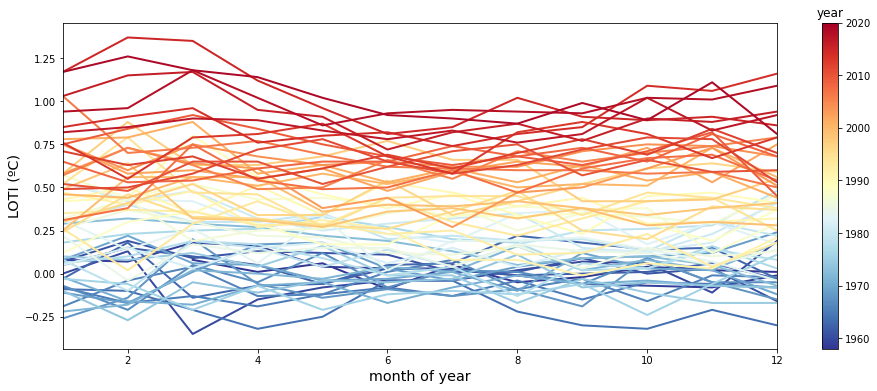

In [12]:
ax = tsf.viz.plot_seasonal_periods(data["LOTI"].groupby(by=data.index.year), "month", cmap="RdYlBu_r")
_ = ax.set_xlabel("month of year")
_ = ax.set_ylabel("LOTI (ºC)")
_ = ax.figure.axes[-1].set_title("year")

From this seasonal plot, we can see that the time series of temperature anomalies doesn't have a strong seasonal component. This is likely because each month's temperature is compared to the corresponding month's temperature averaged over the reference period — that is, the values are normalized by both time and place. Still, it looks as if recent winter months are more often seeing larger temperature anomalies than summer months. (Which, yikes!)

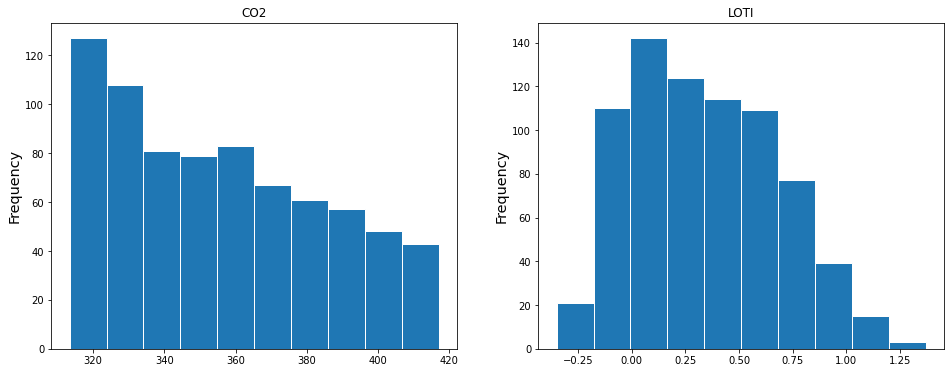

In [13]:
fig, axes = plt.subplots(ncols=2)
_ = data["CO2"].plot.hist(title="CO2", ec="white", ax=axes[0])
_ = data["LOTI"].plot.hist(title="LOTI", ec="white", ax=axes[1])

Both our predictor and forecast variables aren't normally distributed, with `CO2` more significantly skewed, but the method through we which we'll fit our model (ordinary least squares aka OLS) doesn't require normality of the variables here. Plus, the skew isn't _too_ extreme, so there's no need to transform the variables via logarithm or Box-Cox. At least, not on a first pass...

Now, let's better describe the relationship between the two variables.

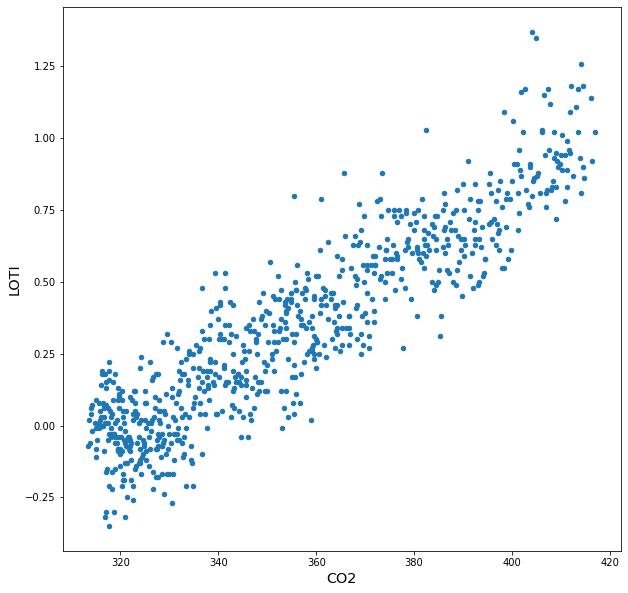

In [14]:
_ = data.plot.scatter("CO2", "LOTI", figsize=(10, 10))

Again we see a strong, linear relationship between the predictor and forecast variables. We also don't see any obvious outlier values, so we won't have to remove observations or otherwise worry about skewed regression model fits.

In [15]:
data.corr(method="spearman")

,LOTI,CO2
LOTI,1.000000,0.906585
CO2,0.906585,1.000000


As anticipated, there's a strong positive correlation of ~0.91 between the predictor and forecast variables, where for the Spearman rank correlation used above, +1 or -1 indicates a perfect monotonic relationship and 0 indicates no relationship between the ranked values.

Based on what we found in step 2, we can be fairly confident that increasing CO2 concentrations in the atmosphere do indeed _cause_ increasingly positive temperature anomalies. However, it's important to note that, when it comes to forecasting, we don't actually need a _causal_ relationship — a correlation will do just fine! Including causal relationships in a model can make for better, more interpretable forecasts, but oftentimes the phenomenon under study has complex and/or unmeasured causes.

## model training and evaluation

Now we're ready to fit a standard linear model to the data — no need for specialized time series models. In this situation, I generally prefer `scikit-learn`'s functionality and API to `statsmodels` — though either should work just fine — because it's focused on ease-of-use, fitting the best model possible, and making predictions. That said, `statsmodels` offers much more in the way of model diagnostics and statistical tests that we'll otherwise have to implement ourselves. So, let's split the difference and use `statsmodels` for the core modeling with `scikit-learn` for metrics and data splits (plus a couple equivalent implementations in sklearn, for reference).

### simple linear regression

Without further ado, let's fit a linear model to our data using least squares estimation, which finds the coefficients $\beta_{0}$ and $\beta_{1}$ that minimize the sum of squared errors. We'll do a simple split of the full dataset into training and test sets, where the test set is comprised of the most recent 10 years of observations — a decent approximation of the forecast we'd like to make.

In [16]:
nobs_test = 12 * 10
data_train = data.iloc[:-nobs_test, :]
data_test = data.iloc[-nobs_test:, :]
data_train.shape, data_test.shape

((634, 2), (120, 2))

In [17]:
# for reference: the scikit-learn equivalent
X_train = data_train[["CO2"]]
y_train = data_train["LOTI"]

model = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(X_train, y=y_train)
print(f"beta0 = {model.intercept_}\nbeta1 = {model.coef_[0]}")
yhat = pd.Series(data=model.predict(X_train), index=y_train.index)
residuals = y_train - yhat

beta0 = -3.4206568539261357
beta1 = 0.010577332694586201


In [18]:
X_train = data_train["CO2"]
y_train = data_train["LOTI"]

model = sm.OLS(y_train, sm.add_constant(X_train), hasconst=True).fit()
print(model.params)
yhat = model.fittedvalues
residuals = model.resid
model.summary()

const   -3.420657
CO2      0.010577
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   LOTI   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     1895.
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          2.47e-192
Time:                        14:17:38   Log-Likelihood:                 364.80
No. Observations:                 634   AIC:                            -725.6
Df Residuals:                     632   BIC:                            -716.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4207      0.084    -40.508      0.000      -3.586      -3.255
CO2            0.0106      0.000     43.526      0.000       0.010       0.011
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   0.813
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.381
Skew:                           0.060   Prob(JB):                        0.826
Kurtosis:                       2.992   Cond. No.                     5.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's interpret our fit model's parameters:

- The expected global temperature anomaly at a CO2 concentration of 0 ppm would be -3.4ºC. However, given the complex dynamics of the system we're modeling, it's likely that our simple linear relationship will _not_ continue to an extreme value of `CO2 = 0`. The intercept term is important to our model, but we should always keep in mind the limits of its applicability.
- For every 1ppm increase in atmospheric CO2 concentration, we expect an increase of 0.01ºC in global temperature anomaly. That doesn't sound like much until you consider how quickly CO2 concentrations have been rising year-over-year...

How do our fitted values (in-sample predictions) compare to the true values?

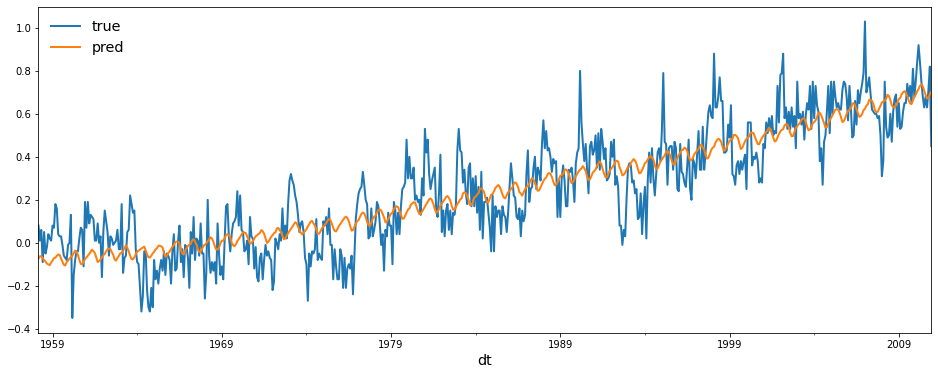

In [19]:
_ = tsf.viz.plot_time_series([y_train, yhat], labels=["true", "pred"], subplots=False)

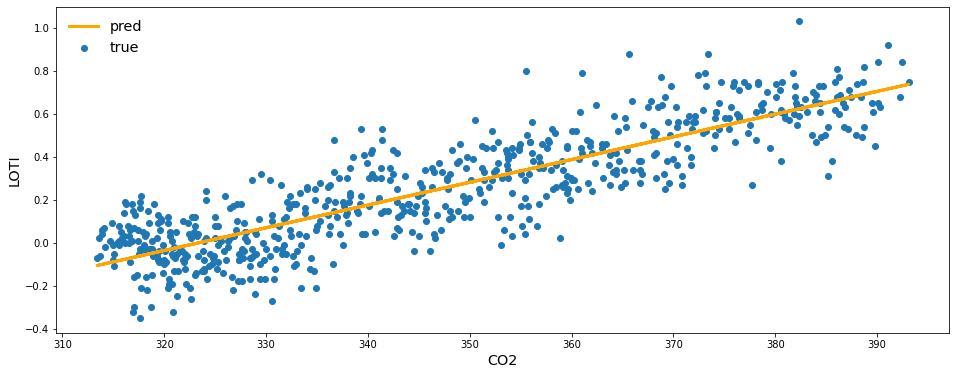

In [20]:
fig, ax = plt.subplots()
_ = ax.scatter(X_train, y_train, label="true")
_ = ax.plot(X_train, yhat, lw=3, label="pred", color="orange")
_ = ax.set_xlabel("CO2")
_ = ax.set_ylabel("LOTI")
_ = ax.legend()

Not _bad_, actually, for a simple linear regression model with only one predictor variable. Let's check the goodness of fit using a couple different metrics:

- **mean squared error:** $\text{MSE} \left( y, 
\hat{y} \right) = \frac{1}{T} \sum \left( y_{t} - \hat{y}_{t} \right)^{2}$, which measures the quality of a fit model based on its variance and bias; values closer to 0 are better
- **coefficient of determination:** $R^{2} \left( y, \hat{y} \right) = 1 - \left( \sum \left( y_{t} - \hat{y}_{t} \right)^{2} / \sum \left( y_{t} - \bar{y} \right)^{2} \right)$, which gives the proportion of variation in the dependent variable accounted for by the independent variable(s); it typically ranges from 1.0 (predicted and observed values are identical) to 0 (no relationship between predicted and observed values)
- **Adjusted $R^{2}$:** $R_{adj}^{2} = 1 - \left( \left( 1 - R^{2} \right) \left( T - 1 \right) / \left( T - p - 1 \right) \right)$, which adjusts the standard to penalize increasing number of predictor variables and avoid over-fitting; its value is similar to but strictly less than $R^{2}$

In [21]:
# sklearn.metrics.mean_squared_error(y_train, yhat, squared=True)  # => sklearn equivalent
model.mse_resid

0.018583020076225303

In [22]:
# sklearn.metrics.r2_score(y_train, yhat)  # => sklearn equivalent
model.rsquared

0.7498544932448972

In [23]:
# tsf.stats.adjusted_r2_score(y_train, yhat, model)  # => sklearn equivalent
model.rsquared_adj

0.7494586933924365

We should also check the residuals to ensure that the assumptions we've made in using this linear regression model hold:

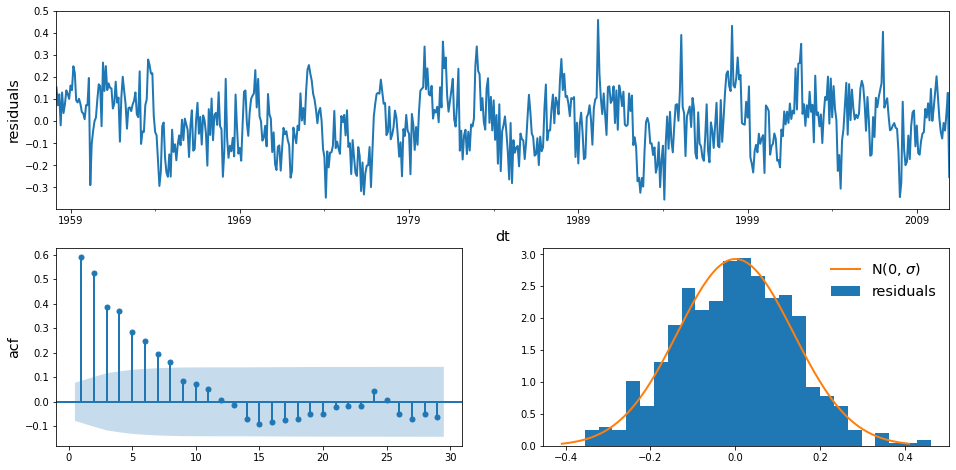

In [24]:
_ = tsf.viz.plot_residuals_diagnostics(residuals, acf_kw={"zero": False}, hist_kw={"bins": 25}, figsize=(16, 8))

In [25]:
sm.stats.stattools.durbin_watson(residuals)

0.8129484501083962

The residual values are indeed distributed normally about zero, which is good.

There's some amount of positive autocorrelation, as visible in the correlogram as well as Durbin-Watson test statistic (values range from 0 to 4, where 2 indicates no autocorrelation; we're roughly in the middle of the positive range). As a result, our forecast intervals may be larger than they need to be, or we may consider adding lagged values of the dependent variable to the model to reduce the residuals' autocorrelation. Or, there are more sophisticated models that can handle autocorrelated residuals.

We also want to make sure that they're not related to the predictor variable or fitted values:

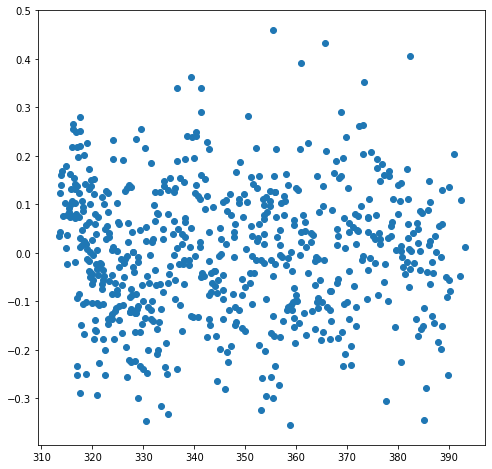

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = ax.scatter(X_train, residuals)

In [27]:
X_train.corr(residuals, method="spearman")

-0.022483212667174356

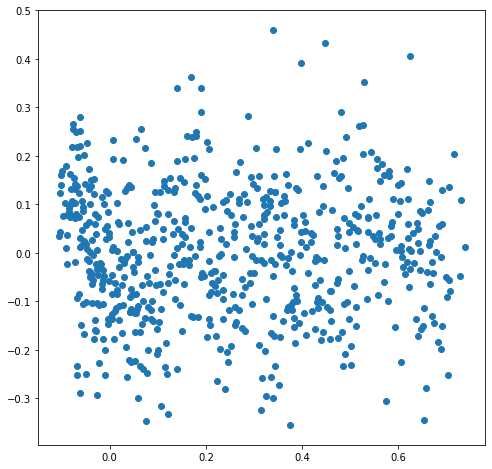

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = ax.scatter(yhat, residuals)

In [29]:
yhat.corr(residuals, method="spearman")

-0.022483212667174356

All good! Our residuals are _homoscedastic_.

As mentioned in the "time series forecasting basics" notebook, there are fancier ways to split the dataset into train/test sets. One such method is a time series-specific variation of cross-validation, in which the dataset is split into $k$ "folds" (evenly-sized subsets of — in this variation — _sequential_ values), then the training set is taken to be the first $k$ folds and the test set is the ($k + 1$)th fold. Unlike typical cross-validation strategies, here successive training sets are supersets of the preceding ones.

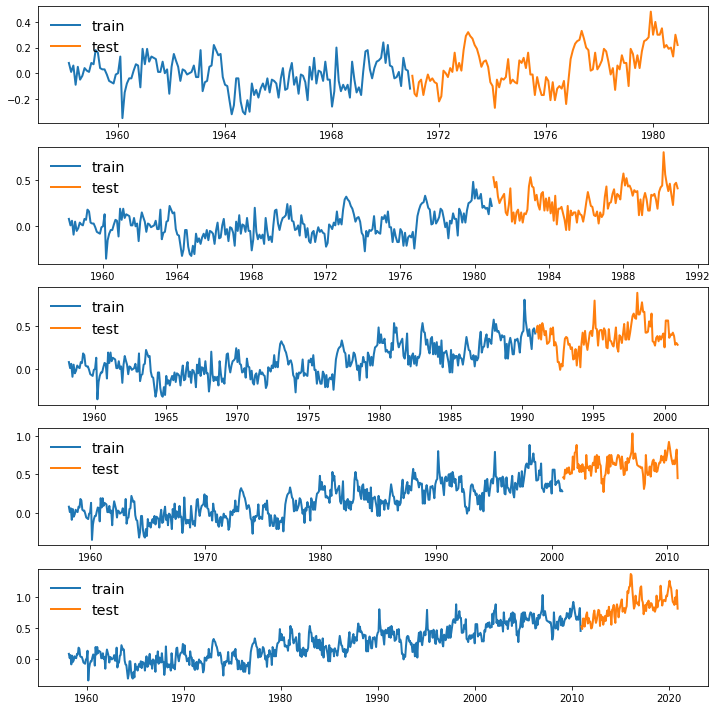

In [30]:
n_splits = 5
data_splits = sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits, gap=0, test_size=nobs_test).split(data)

fig, axes = plt.subplots(figsize=(12, 2.5 * n_splits), nrows=n_splits)
for ax, (train_idxs, test_idxs) in zip(axes, data_splits):
    data_train = data.iloc[train_idxs, :]
    data_test = data.iloc[test_idxs, :]
    _ = ax.plot(data_train.index, data_train["LOTI"], label="train")
    _ = ax.plot(data_test.index, data_test["LOTI"], label="test")
    _ = ax.legend(loc="upper left")

Note the changing time periods on the x-axis!

In [31]:
# here's where scikit-learn starts to shine — they make this easy!
# this gives us train- and test-set model scores for each cv split
X = data[["CO2"]]
y = data["LOTI"]

cv_scores = sklearn.model_selection.cross_validate(
    sklearn.linear_model.LinearRegression(fit_intercept=True),
    X,
    y,
    cv=sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits, gap=0, test_size=nobs_test),
    scoring={
        "mse": sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False),
        "r2": sklearn.metrics.make_scorer(sklearn.metrics.r2_score, greater_is_better=True),
    },
    return_train_score=True,
)
cv_scores

{'fit_time': array([0.00209808, 0.00231934, 0.00182343, 0.00201201, 0.00211477]),
 'score_time': array([0.00180984, 0.00166678, 0.0019238 , 0.00191808, 0.00156903]),
 'test_mse': array([-0.03389716, -0.02847457, -0.0218991 , -0.01744092, -0.02165954]),
 'train_mse': array([-0.01414586, -0.01736717, -0.01834682, -0.01906204, -0.0185244 ]),
 'test_r2': array([-0.39470932, -0.30135789,  0.13150407, -0.19704358,  0.38690303]),
 'train_r2': array([0.00169175, 0.13272497, 0.46098915, 0.59316071, 0.74985449])}

In [32]:
cv_scores = collections.defaultdict(list)
n_splits = 5
data_splits = sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits, gap=0, test_size=nobs_test).split(data)
for train_idxs, test_idxs in data_splits:
    data_train = data.iloc[train_idxs, :]
    data_test = data.iloc[test_idxs, :]

    model = sm.OLS(data_train["LOTI"], sm.add_constant(data_train["CO2"]), hasconst=True).fit()
    yhat_test = model.predict(sm.add_constant(data_test["CO2"]))
    cv_scores["train_mse"].append(model.mse_resid)
    cv_scores["train_r2"].append(model.rsquared)
    cv_scores["test_mse"].append(sklearn.metrics.mean_squared_error(data_test["LOTI"], yhat_test, squared=True))
    cv_scores["test_r2"].append(sklearn.metrics.r2_score(data_test["LOTI"], yhat_test))
dict(cv_scores)

{'train_mse': [0.014331988405853804,
  0.01749487183956457,
  0.018440423909184305,
  0.019136496669692426,
  0.018583020076225303],
 'train_r2': [0.0016917497985403651,
  0.13272497169137865,
  0.46098915136898677,
  0.5931607111062742,
  0.7498544932448972],
 'test_mse': [0.03389716058505806,
  0.028474569274908428,
  0.021899100850742988,
  0.017440916577957214,
  0.0216595407422566],
 'test_r2': [-0.3947093195703286,
  -0.3013578948896758,
  0.13150406600713682,
  -0.19704357520657645,
  0.3869030329811288]}

The difference in scoring results for the train vs test sets here underscore how important it is to evaluate models on held-out data. In particular, we can see that test performance in the earlier splits are quite bad, probably because of the change in trend from flattish to positive somewhere around 1975 that we noted earlier. This suggests that our model is too simple — we'll have to come up with something better.

### multiple linear regression

Clearly, accounting for a couple aspects of the data could help our linear regression model: for starters, the non-linear trend and hints of seasonality in the dependent variable. This calls for some feature engineering and multiple regression.

#### trend(s)

A simple way to model a linear trend in the dependent variable is to use $x_{1, t} = t$ as a predictor variable. In our case, however, we want to model the early years' flattish trend and the later years' upward trend. Although we could try using a quadratic term $x_{2, t} = t^{2}$ in the model, such higher-order terms may lead to unrealistic forecasts. Instead, we'll model a _piecewise_ linear trend, with a bend or "knot" at time $\tau$:

$$
\begin{align}
    x_{1, t} &= t \\
    x_{2, t} &= (t - \tau)_{+} = \
    \begin{cases}
        0 &\text{if $t < \tau$} \\
        t - \tau &\text{if $t >= \tau$}
    \end{cases}
\end{align}
$$

When fit, the model's $\beta_{1}$ coefficient associated with $x_{1, t}$ will give the slope of the initial trend, while $\beta_{2}$ will give the slope of the latter trend. Note that we'll just eyeball a suitable value for the knot — _squints at graph_, let's say `"1977-01-01"` — but there are more principled ways of identifying bends in the data.

#### seasonality

We noticed in the seasonal plot of `LOTI` that, at least in recent years, temperature anomalies in winter months appear to be larger than the other months of the year. To account for this, we can add seasonal "dummy variables" into our model. In this case, we'll transform observations' timestamps into ordinal quarterly values (e.g. `1958-02-01` => `1`, `1958-04-01` => `2`), then "dummy-encode" that variable such that each distinct value is assigned to its own binary column.

Actually — and this is important — we'll only use 3 dummy variables to handle the 4 quarters of the year, since the 4th (as specified when all 3 values are 0) is accounted for by the intercept term. Including the 4th dummy variable would mess up our regression model, owing to the problem of multicollinearity: any 3 of the variables would be perfectly correlated with the 4th. In the presence of perfectly correlated predictor variables, the uncertainties on the regression model's coefficients can be large, which has implications for understanding the relative contributions of the variables, reliability of forecasts, and more. So let's not fall into that trap.

In [33]:
import statsmodels.tsa.deterministic

In [34]:
const = statsmodels.tsa.deterministic.TimeTrend(constant=True, order=0)
pwlt = tsf.features.PiecewiseLinearTrend(knots=["1977-01-01"])
quarters = tsf.features.DatetimeAttributeSeasonality("quarter")

dp = statsmodels.tsa.deterministic.DeterministicProcess(data.index, additional_terms=[const, pwlt, quarters])
data_multi = pd.merge(data, dp.in_sample(), left_index=True, right_index=True)
data_multi

,LOTI,CO2,const,trend(0),trend(1),quarter=2,quarter=3,quarter=4
dt,,,,,,,,
1958-03-01,0.08,316.425000,1.0,1.0,0.0,0,0,0
1958-04-01,0.01,317.438462,1.0,2.0,0.0,1,0,0
1958-05-01,0.06,317.471111,1.0,3.0,0.0,1,0,0
1958-06-01,-0.09,316.598142,1.0,4.0,0.0,1,0,0
1958-07-01,0.05,315.753333,1.0,5.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...
2020-08-01,0.87,412.551724,1.0,750.0,524.0,0,1,0
2020-09-01,0.99,411.315385,1.0,751.0,525.0,0,1,0
2020-10-01,0.89,411.292143,1.0,752.0,526.0,0,0,1


In [35]:
# _ = pd.plotting.scatter_matrix(data_multi, figsize=(12, 12))

In [36]:
X = data_multi.drop(columns=["LOTI"])
y = data_multi["LOTI"]

model = sm.OLS(y, X, hasconst=True).fit()
yhat = model.fittedvalues
residuals = model.resid
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   LOTI   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     666.8
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          5.27e-296
Time:                        14:17:41   Log-Likelihood:                 443.31
No. Observations:                 754   AIC:                            -872.6
Df Residuals:                     747   BIC:                            -840.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CO2            0.0133      0.002      6.077      0.000       0.009       0.018
const         -4.1904      0.690     -6.077      0.000      -5.544      -2.837
trend(0)      -0.0005      0.000     -2.930      0.003      -0.001      -0.000
trend(1)       0.0002      0.000      0.971      0.332      -0.000       0.001
quarter=2     -0.0725      0.015     -4.985      0.000      -0.101      -0.044
quarter=3     -0.0389      0.015     -2.664      0.008      -0.068      -0.010
quarter=4     -0.0179      0.015     -1.183      0.237      -0.048       0.012
==============================================================================
Omnibus:                        2.010   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.911
Skew:                           0.065   Prob(JB):                        0.385
Kurtosis:                       3.210   Cond. No.                     8.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looks like most of our predictor variables are useful to the model, though a couple with large-ish p-values could conceivably be dropped. There are methods for selecting variables in a principled way, but for example purposes, we'll just roll with this model as-is.

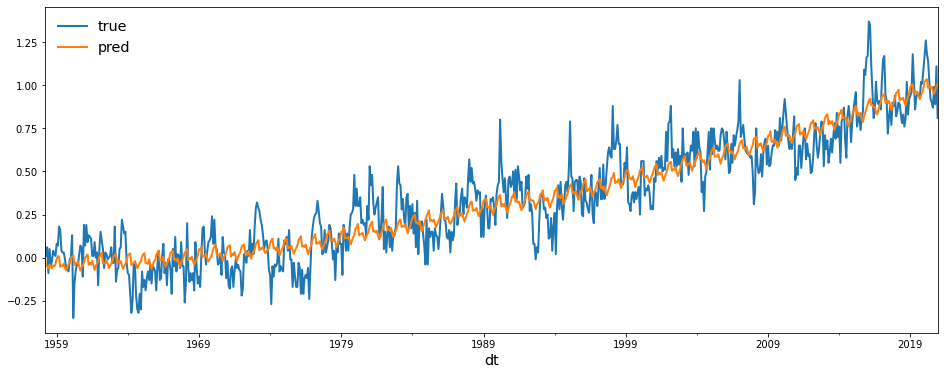

In [37]:
_ = tsf.viz.plot_time_series([y, yhat], labels=["true", "pred"], subplots=False)

That is indeed a nicer-looking fit than our previous, simpler model! That said, its performance on our test set is a mixed bag in comparison... My guess is that the more complex model requires a longer range of observations to get a good fit for all the parameters.

In [38]:
cv_scores = collections.defaultdict(list)
n_splits = 5
data_splits = sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits, gap=0, test_size=nobs_test).split(data_multi)
for train_idxs, test_idxs in data_splits:
    data_train = data_multi.iloc[train_idxs, :]
    data_test = data_multi.iloc[test_idxs, :]

    model = sm.OLS(data_train["LOTI"], data_train.drop(columns="LOTI"), hasconst=True).fit()
    yhat_test = model.predict(data_test.drop(columns="LOTI"))
    cv_scores["train_mse"].append(model.mse_resid)
    cv_scores["train_r2"].append(model.rsquared)
    cv_scores["test_mse"].append(sklearn.metrics.mean_squared_error(data_test["LOTI"], yhat_test, squared=True))
    cv_scores["test_r2"].append(sklearn.metrics.r2_score(data_test["LOTI"], yhat_test))
    
    # _ = tsf.viz.plot_time_series([data_test["LOTI"], yhat_test], labels=["true", "pred"], subplots=False)
dict(cv_scores)

{'train_mse': [0.014065920148418619,
  0.015025338511919294,
  0.01695408014640063,
  0.01819912599349126,
  0.017814476893605692],
 'train_r2': [0.046008539689704975,
  0.26883953738403477,
  0.5107557437471815,
  0.6168675097664605,
  0.7620969844856715],
 'test_mse': [0.023293137596437977,
  0.14399043676631276,
  0.03344273149027286,
  0.018959671502377026,
  0.022751083338941745],
 'test_r2': [0.04159653708262345,
  -5.580717336419002,
  -0.32630451445825615,
  -0.3012821234769003,
  0.3560057271073275]}

In [39]:
X = data_multi.drop(columns=["LOTI"])
y = data_multi["LOTI"]

model = sm.OLS(y, X, hasconst=True).fit()

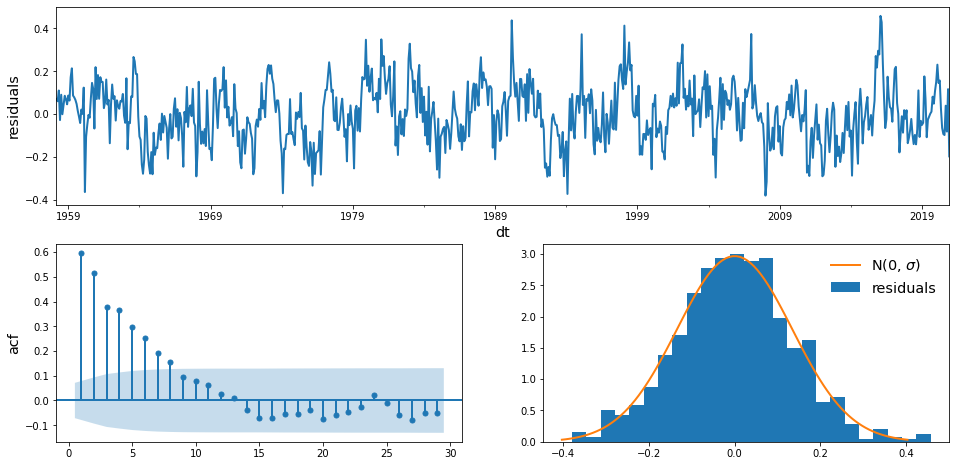

In [40]:
_ = tsf.viz.plot_residuals_diagnostics(model.resid, acf_kw={"zero": False}, hist_kw={"bins": 25}, figsize=(16, 8))

In [41]:
model.fittedvalues.corr(model.resid, method="spearman")

-0.01695262619485345

In [42]:
X.drop(columns="const").corrwith(model.resid, method="spearman")

CO2         -0.018856
trend(0)    -0.020192
trend(1)     0.010420
quarter=2   -0.011550
quarter=3    0.008415
quarter=4    0.003423
dtype: float64

The residuals diagnostics are much as they were for the simple linear regression model: normally distributed about zero, constant variance, uncorrelated with fitted values or predictor variables, but with some positive autocorrelation. To properly model this data, we should probably use a more sophisticated models that can handle autocorrelated residuals.

## forecasting

For time series regression models, there are two fundamental types of forecast:

- **ex-ante:** true forecasts that rely only on information available in advance of producing the forecast; unfortunately, this requires estimating future values for each of the predictor variables (e.g. using a fit ETS model to forecast CO2 concentrations)
- **ex-post:** forecasts that use later information about the predictor variables; mostly used for studying the behavior and uncertainty of regression forecasting models

A common case is "scenario-based" forecasting, where forecasts are produced assuming different scenarios for the predictors — for example: high, medium, and low CO2 emissions trajectories.

In [43]:
steps = 12 * 10
last_known_co2 = data["CO2"].iat[-1]

In [44]:
def get_mult_factors(start, end, steps):
    return np.arange(start, end, (end - start) / steps)


ets_result = (
    sm.tsa.ETSModel(
        data["CO2"],
        trend="mul",
        seasonal="mul",
        error="add",
        seasonal_periods=12,
        initialization_method="estimated",
    )
    .fit()
)
co2_fcast_no_change = ets_result.forecast(steps=steps)
co2_fcast_flat = tsf.naive.naive_seasonal_forecast(data["CO2"], 12, steps=steps)
co2_fcast_50pct_2030 = (
    co2_fcast_no_change -
    ((co2_fcast_no_change - co2_fcast_flat).diff(1).fillna(0.0) * get_mult_factors(0.0, 0.5, steps)).cumsum()
)
co2_fcast_100pct_2030 = (
    co2_fcast_no_change -
    ((co2_fcast_no_change - co2_fcast_flat).diff(1).fillna(0.0) * get_mult_factors(0.0, 1.0, steps)).cumsum()
)

co2_fcast_scenarios = pd.DataFrame(
    data={
        "no change": co2_fcast_no_change,
        "-50% by 2030": co2_fcast_50pct_2030,
        "net-zero by 2030": co2_fcast_100pct_2030,
    },
    index=co2_fcast_no_change.index,
)
co2_fcast_scenarios

,no change,-50% by 2030,net-zero by 2030
2021-01-01,415.500150,415.500150,415.500150
2021-02-01,416.374138,416.373664,416.373190
2021-03-01,417.452827,417.447107,417.441386
2021-04-01,418.971573,418.966644,418.961716
2021-05-01,419.690578,419.688199,419.685820
...,...,...,...
2030-08-01,437.196857,431.617644,426.038432
2030-09-01,435.295656,430.037793,424.779930
2030-10-01,435.457937,430.109632,424.761326
2030-11-01,437.128020,431.798457,426.468893


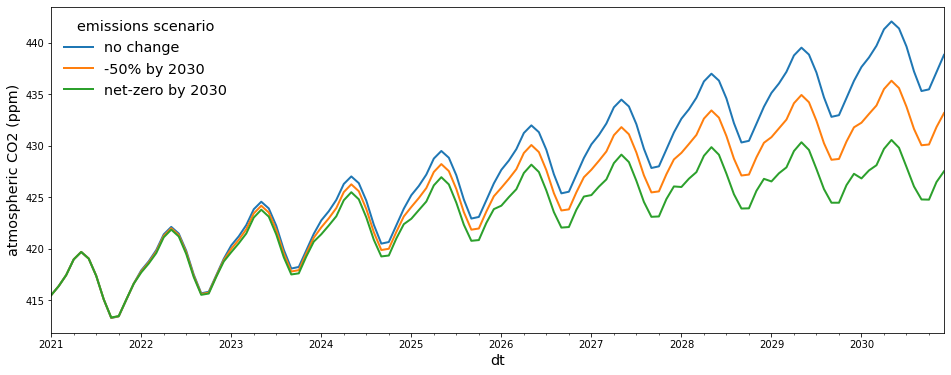

In [45]:
ax = co2_fcast_scenarios.plot(xlabel="dt", ylabel="atmospheric CO2 (ppm)")
ax.get_legend().set_title("emissions scenario", prop={"size": "x-large"})

Note: These forecasts aren't fancy — among other things, they assume linear decreases in emissions over the decade. But this is just for example purposes...

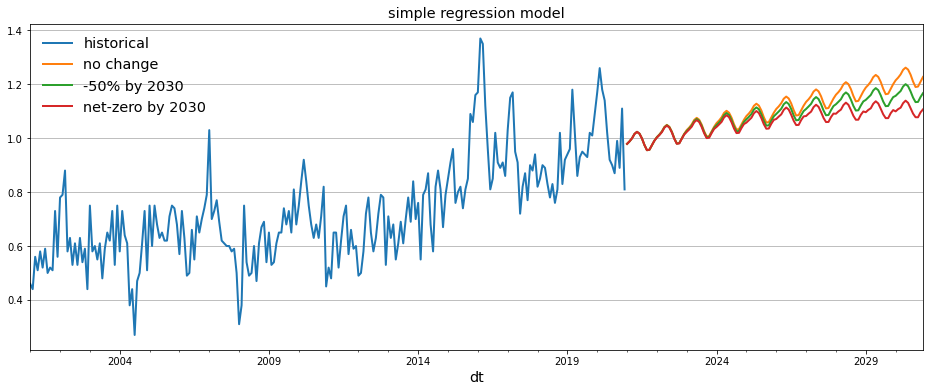

In [46]:
uni_model = sm.OLS(data["LOTI"], sm.add_constant(data["CO2"]), hasconst=True).fit()

ax = tsf.viz.plot_time_series(
    [
        data["LOTI"].tail(steps * 2),
        uni_model.predict(sm.add_constant(co2_fcast_scenarios["no change"])),
        uni_model.predict(sm.add_constant(co2_fcast_scenarios["-50% by 2030"])),
        uni_model.predict(sm.add_constant(co2_fcast_scenarios["net-zero by 2030"])),
    ],
    ["historical", "no change", "-50% by 2030", "net-zero by 2030"],
    subplots=False
)
ax.set_title("simple regression model", fontsize="x-large")
ax.grid(True, which="major", axis="y")

In [47]:
(
    uni_model.predict(sm.add_constant(co2_fcast_scenarios["no change"])).iat[-1] -
    uni_model.predict(sm.add_constant(co2_fcast_scenarios["no change"])).iat[0]
)

0.2482812641797496

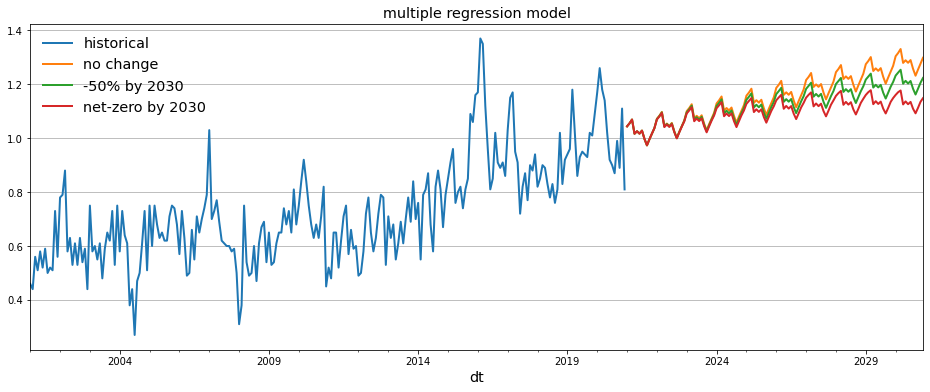

In [48]:
multi_model = sm.OLS(data_multi["LOTI"], data_multi.drop(columns="LOTI"), hasconst=True).fit()

scenarios = ["no change", "-50% by 2030", "net-zero by 2030"]
scenario_preds = []
for scenario in scenarios:
    fcast_data = pd.merge(
        co2_fcast_scenarios[[scenario]].rename(columns={scenario: "CO2"}),
        dp.out_of_sample(steps=steps),
        left_index=True,
        right_index=True,
    )
    scenario_preds.append(multi_model.predict(fcast_data))

ax = tsf.viz.plot_time_series(
    [data["LOTI"].tail(steps * 2)] + scenario_preds,
    ["historical"] + scenarios,
    subplots=False,
)
ax.set_title("multiple regression model", fontsize="x-large")
ax.grid(True, which="major", axis="y")

In [49]:
scenario_preds[0].iat[-1] - scenario_preds[0].iat[0]

0.25452751448812116

In comparing the two forecasts, we can see that the multiple regression model has a more complex, slightly higher forecast than the simple regression model. Under the baseline "no change" scenario, the multi model forecasts an increase of ~0.255ºC in global mean temperature anomaly come 2030, while the simple model forecasts ~0.248ºC. That doesn't seem like much, but keep in mind that every tenth of a degree of warming prevented will result in vastly reduced human misery and environmental damage. Also, don't forget about the confidence intervals — the upper bound of this model's predictions hit +1.4ºC in 2030. That's _hot_.

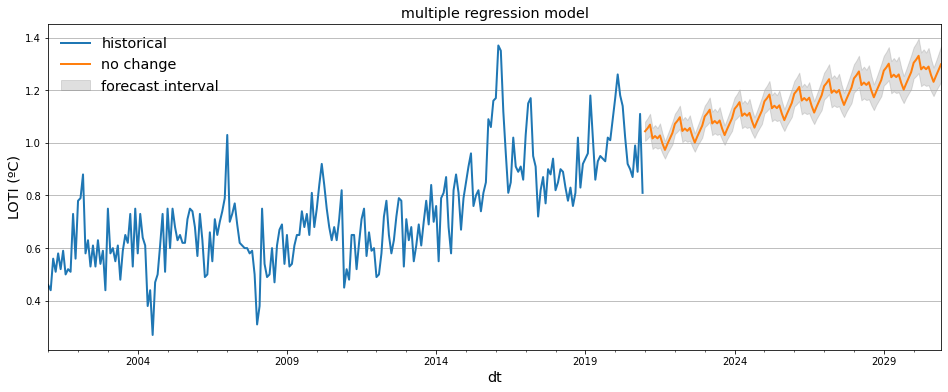

In [50]:
scenario = "no change"
fcast_data = pd.merge(
    co2_fcast_scenarios[[scenario]].rename(columns={scenario: "CO2"}),
    dp.out_of_sample(steps=steps),
    left_index=True,
    right_index=True,
)
preds = multi_model.get_prediction(fcast_data).summary_frame()

ax = tsf.viz.plot_time_series(
    [data["LOTI"].tail(steps * 2), preds["mean"]],
    ["historical", "no change"],
    subplots=False,
)
_ = ax.fill_between(
    preds.index, preds["mean_ci_upper"], preds["mean_ci_lower"],
    color="gray", alpha=0.25, label="forecast interval",
)
_ = ax.legend()
ax.set_title("multiple regression model", fontsize="x-large")
ax.set_ylabel("LOTI (ºC)")
ax.grid(True, which="major", axis="y")

Clearly, global warming and related climate change will continue getting worse for the next decade (and beyond) — how _much_ worse is up to us.

## references

As inspiration and primary reference, I relied on an excellent online textbook:

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. https://otexts.com/fpp3. 